In [1]:
import illustris_python.groupcat as gc
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
basePath = "/Users/forero/Illustris_data/TNG300-1/"

halo_fields = ['GroupFirstSub', 'Group_M_Crit200', 'Group_R_Crit200', 'Group_M_Mean200',
               'GroupNsubs', 'GroupPos', 'GroupVel', 'GroupFirstSub', 'GroupMassType']
halos = gc.loadHalos(basePath,99, fields=halo_fields) # the selection is based on the FOF groups

subhalo_fields = ['SubhaloMass','SubhaloSFRinRad', 'SubhaloPos', 'SubhaloVmax','SubhaloMassType',
                  'SubhaloVel', 'SubhaloParent', 'SubhaloGrNr', 'SubhaloStellarPhotometrics']
subhalos = gc.loadSubhalos(basePath,99, fields=subhalo_fields)
header = gc.loadHeader(basePath,99)


In [3]:
subhalo_stellar_mass = subhalos['SubhaloMassType'][:,4]
BoxSize = header['BoxSize']
hubble = header['HubbleParam']

In [10]:
ii = subhalos['SubhaloVmax']>200 # in units of km/s
print(np.count_nonzero(ii))

39222


Text(0.5,1,'Massive Galaxies')

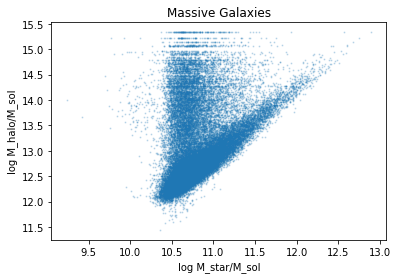

In [11]:
plt.scatter(np.log10(subhalo_stellar_mass[ii]/header['HubbleParam'])+10, 
        np.log10(halos['Group_M_Mean200'][subhalos['SubhaloGrNr'][ii]]/header['HubbleParam'])+10, s=1.0, alpha=0.2)
plt.xlabel('log M_star/M_sol')
plt.ylabel('log M_halo/M_sol')
plt.title('Massive Galaxies')

Text(0.5,1,'Massive Galaxies')

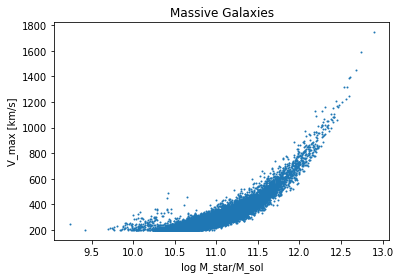

In [12]:
plt.scatter(np.log10(subhalo_stellar_mass[ii]/header['HubbleParam'])+10, subhalos['SubhaloVmax'][ii], s=1.0)
plt.xlabel('log M_star/M_sol')
plt.ylabel('V_max [km/s]')
plt.title('Massive Galaxies')

In [13]:
S_pos = subhalos['SubhaloPos'][ii]
S_vel = subhalos['SubhaloVel'][ii]
S_vmax = subhalos['SubhaloVmax'][ii]
S_stellar_mass = subhalo_stellar_mass[ii]
S_parent_fof = halos['Group_M_Mean200'][subhalos['SubhaloGrNr'][ii]]
n_S = len(S_pos)

In [14]:
#pad boxes around the S3 positions to mimic periodic boundary conditions
S_pad_pos = S_pos.copy()
S_pad_vel = S_vel.copy()
S_pad_vmax = S_vmax.copy()
S_pad_stellar_mass = S_stellar_mass.copy()
S_pad_fof = S_parent_fof.copy()
S_pad_id = np.arange(n_S)
for i in (0,1,-1):
    for j in (0,1,-1):
        for k in (0,1,-1):
            new_pos = S_pos.copy()
            if(i):
                new_pos[:,0] = new_pos[:,0] + i*BoxSize
            if(j):
                new_pos[:,1] = new_pos[:,1] + j*BoxSize
            if(k):
                new_pos[:,2] = new_pos[:,2] + k*BoxSize
                
            if((i!=0) | (j!=0) | (k!=0)):
                S_pad_pos = np.append(S_pad_pos, new_pos, axis=0)
                S_pad_vel = np.append(S_pad_vel, S_vel, axis=0)
                S_pad_vmax = np.append(S_pad_vmax, S_vmax)
                S_pad_stellar_mass = np.append(S_pad_stellar_mass, S_stellar_mass)
                S_pad_id = np.append(S_pad_id, np.arange(n_S))
                S_pad_fof = np.append(S_pad_fof, S_parent_fof)

In [15]:
nbrs_S = NearestNeighbors(n_neighbors=20, algorithm='ball_tree').fit(S_pad_pos)
dist_S, ind_S = nbrs_S.kneighbors(S_pad_pos)
print(S_pad_pos.shape)
print(dist_S.shape)

(1058994, 3)
(1058994, 20)


In [46]:
neighbor_index = ind_S[:,1]
neighbor_list = ind_S[:,2:]
print(np.shape(neighbor_list))

n_pairs = 0

halo_A_id = np.empty((0), dtype=int)
halo_B_id = np.empty((0), dtype=int)

for i in range(n_S):
    l = neighbor_index[neighbor_index[i]]% n_S
    j = neighbor_index[i] % n_S
    
    other_j = neighbor_list[i,:] % n_S
    other_l = neighbor_list[neighbor_index[i],:] % n_S
    
    if((i==l) & (not (j in halo_A_id)) & (not (i in halo_B_id))): # first check to find mutual neighbors
        if((dist_S[i,1]/hubble > 700.0)): #check on the distance between the two galaxies
            stellar_mass_i = S_pad_stellar_mass[i]
            stellar_mass_j = S_pad_stellar_mass[j]
            mass_limit = min([stellar_mass_i, stellar_mass_j])
                
            pair_d = dist_S[i,1] # This is the current pair distance
            dist_limit = pair_d * 3.0 # exclusion radius for massive structures

            
            massive_close_to_i = any((dist_S[i,2:]<dist_limit) & (S_pad_stellar_mass[other_j] >= mass_limit))
            massive_close_to_j = any((dist_S[j,2:]<dist_limit) & (S_pad_stellar_mass[other_l] >= mass_limit))
            if((not massive_close_to_i) & (not massive_close_to_j)): # check on massive structures inside exclusion radius
                n_pairs = n_pairs+ 1
                halo_A_id = np.append(halo_A_id, int(i))
                halo_B_id = np.append(halo_B_id, int(j))
                    #print(pair_d)
print(n_pairs)

(1058994, 18)
1370


In [47]:
halo_A = np.array([S_pad_fof[halo_A_id], halos['Group_M_Crit200'][np.int_(S_pad_fof[halo_A_id])], 
                   S_pad_stellar_mass[halo_A_id], S_vmax[halo_A_id],
                   S_pos[halo_A_id,0], S_pos[halo_A_id,1], S_pos[halo_A_id,2],
                   S_vel[halo_A_id,0], S_vel[halo_A_id,1], S_vel[halo_A_id,2]], )
np.savetxt('../data/mstar_selected/summary_halo_A.txt', halo_A.T, 
        fmt="%d %f %f %f %f %f %f %f %f %f", 
           header = "FOF_ID M_FOF[10^10 Msun/h] Mstar[10^10 Msun/h] Vmax [km/s] Pos_xyz [kpc/h] Vel_xyz [km/s]")

halo_B = np.array([S_pad_fof[halo_B_id], halos['Group_M_Crit200'][np.int_(S_pad_fof[halo_B_id])], 
                   S_pad_stellar_mass[halo_B_id], S_vmax[halo_B_id],
                   S_pos[halo_B_id,0], S_pos[halo_B_id,1], S_pos[halo_B_id,2],
                   S_vel[halo_B_id,0], S_vel[halo_B_id,1], S_vel[halo_B_id,2]])
np.savetxt('../data/mstar_selected/summary_halo_B.txt', halo_B.T, 
        fmt="%d %f %f %f %f %f %f %f %f %f", 
           header = "FOF_ID M_FOF[10^10 Msun/h] Mstar[10^10 Msun/h] Vmax [km/s] Pos_xyz [kpc/h] Vel_xyz [km/s]")